<a href="https://colab.research.google.com/github/bundickm/AB-Demo/blob/master/Michael_Bundick_DS_U1_S5_Project_Scratchbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install --upgrade seaborn

    100% |████████████████████████████████| 215kB 15.7MB/s 
  Found existing installation: seaborn 0.7.1
    Uninstalling seaborn-0.7.1:
      Successfully uninstalled seaborn-0.7.1


###Load and Engineer Some Features

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [0]:
games = pd.read_csv('games_all.csv').drop(['Unnamed: 0','Unnamed: 0.1','median'],axis='columns')

In [0]:
games['id'] = games['id'].astype(int)
games = games.set_index('id')

In [0]:
#0 doesnt make sense for these, set to null
games[['age',
       'best_age',
       'avg_play_time',
       'max_play_time',
       'min_play_time',
       'lang_dependance',
       'weight',
       'max_players',
       'min_players']] = games[['age',
                                  'best_age',
                                  'avg_play_time',
                                  'max_play_time',
                                  'min_play_time',
                                  'lang_dependance',
                                  'weight',
                                  'max_players',
                                  'min_players']].replace(0,np.NaN)
#a couple of games with less than 30 votes somehow snuck in--remove them
games = games[games['rating_votes'] >= 30]

In [0]:
spinoffs = []
for i in range(len(games)):
  #'*' and '+' seem to cause issues with str.contains() so set those manually
  if ((games['name'].iloc[i] == 'Clusterf**k!') or 
      (games['name'].iloc[i] == 'Wibbell++') or 
      (games['name'].iloc[i] == '*Star') or 
      (games['name'].iloc[i] == 'F**k. The game')):
    spinoffs.append(0)
  else:
  #rough way to figure out spinoff games, check for the same name
  #this will over estimate on common one word titles and...
  #titles with a single short word
    spinoffs.append((len(games[games['name'].str.contains(
                                            games['name'].iloc[i])])-1))
games['spinoffs'] = spinoffs

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


In [0]:
#Catan has 30 spinoffs, if you are beating it you are well above average
verify_spinoffs = list(games[(games['spinoffs'] > 30)]['name'])
#check the games that are owned the most on BGG, these could be legit spinoffs
print(games[(games['spinoffs'] > 30) & (games['owned'] > games['owned'].mean())]['name'])
#remove the legit spinoff breeders
safe_games = ['Risk','Monopoly','Clue','Catan','Munchkin']
for safe_game in safe_games:
  verify_spinoffs.remove(safe_game)
#assign the rest to 0, this is going to cause a few games to be off...
#a small number on spinoffs - but not like the 16k+ before
games.loc[games['name'].isin(verify_spinoffs),'spinoffs'] = 0

id
13                    Catan
1927               Munchkin
181                    Risk
1406               Monopoly
12                       Ra
1294                   Clue
188                      Go
823       Lord of the Rings
173090             The Game
16496                  Roma
121297                Fleet
3737              Operation
655                  Castle
197405                  Tak
161578           [redacted]
Name: name, dtype: object


In [0]:
games['play_time_range'] = abs(games['max_play_time']-games['min_play_time'])
games['player_range'] = games['max_players']-games['min_players']
games['best_with_dense'] = ((games['best_with'].str.replace('+',''))
                            .astype(float).astype(int))
games['best_with_dense'] = games['best_with_dense'].replace('0',np.NaN)
games['weight_rnd'] = games['weight'].round()

In [0]:
columns = ['name', 'owned', 'bayes_rating', 'weight', 'avg_play_time', 'age', 
 'best_with_dense', 'spinoffs', 'lang_dependance', 'comment_count', 'honor_count', 
 'publish_date', 'best_age', 'max_play_time', 'min_play_time', 'play_time_range',
 'max_players', 'min_players', 'best_with', 'player_range', 'rating_votes', 
 'weight_votes', 'trading', 'wanting', 'wishing', 'rating', 'std_dev', 'weight_rnd',
 'description', 'image']

games = games[columns]
games.head(1)

,name,owned,bayes_rating,weight,avg_play_time,age,best_with_dense,spinoffs,lang_dependance,comment_count,honor_count,publish_date,best_age,max_play_time,min_play_time,play_time_range,max_players,min_players,best_with,player_range,rating_votes,weight_votes,trading,wanting,wishing,rating,std_dev,weight_rnd,description,image
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13,Catan,123608,7.04016,2.3412,120.0,10.0,4,31,2.0,16207,13.0,1995,5.0,120.0,60.0,60.0,4.0,3.0,4.0,1.0,84363,6844,1652,451,4699,7.1943,1.46985,2.0,"In Catan (formerly The Settlers of Catan), pla...",https://cf.geekdo-images.com/original/img/A-0y...


###Explore, Focused on Bayes Rating

In [0]:
games.head()

,name,owned,bayes_rating,weight,avg_play_time,age,best_with_dense,spinoffs,lang_dependance,comment_count,honor_count,publish_date,best_age,max_play_time,min_play_time,play_time_range,max_players,min_players,best_with,player_range,rating_votes,weight_votes,trading,wanting,wishing,rating,std_dev,weight_rnd,description,image
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13,Catan,123608,7.04016,2.3412,120.0,10.0,4,31,2.0,16207,13.0,1995,5.0,120.0,60.0,60.0,4.0,3.0,4.0,1.0,84363,6844,1652,451,4699,7.19430,1.46985,2.0,"In Catan (formerly The Settlers of Catan), pla...",https://cf.geekdo-images.com/original/img/A-0y...
822,Carcassonne,120110,7.32325,1.9259,45.0,8.0,2,25,1.0,16078,12.0,2000,5.0,45.0,30.0,15.0,5.0,2.0,2.0,3.0,84045,6924,1461,498,5337,7.42741,1.30276,2.0,Carcassonne is a tile-placement game in which ...,https://cf.geekdo-images.com/original/img/o4p6...
30549,Pandemic,121076,7.54713,2.4230,45.0,8.0,4,8,2.0,13977,34.0,2008,6.0,45.0,45.0,0.0,4.0,2.0,4.0,2.0,82331,4854,1935,622,7610,7.64064,1.32187,2.0,"In Pandemic, several virulent diseases have br...",https://cf.geekdo-images.com/original/img/j-pf...
68448,7 Wonders,89740,7.69094,2.3406,30.0,10.0,4,1,1.0,11723,50.0,2010,6.0,30.0,30.0,0.0,7.0,2.0,4.0,5.0,68249,3984,1144,1025,9407,7.78348,1.27550,2.0,You are the leader of one of the 7 great citie...,https://cf.geekdo-images.com/original/img/3DP_...
36218,Dominion,87899,7.54537,2.3632,30.0,13.0,3,8,3.0,12115,41.0,2008,6.0,30.0,30.0,0.0,4.0,2.0,3.0,2.0,67698,4669,1791,564,6621,7.64685,1.42680,2.0,(from the back of the box:)<br/><br/>&quot;You...,https://cf.geekdo-images.com/original/img/oN8C...


In [0]:
games.describe()

,owned,bayes_rating,weight,avg_play_time,age,best_with_dense,spinoffs,lang_dependance,comment_count,honor_count,publish_date,best_age,max_play_time,min_play_time,play_time_range,max_players,min_players,player_range,rating_votes,weight_votes,trading,wanting,wishing,rating,std_dev,weight_rnd
count,17168.000000,17168.000000,16857.000000,16735.000000,16043.000000,17168.000000,17168.000000,12126.000000,17168.000000,17168.000000,17168.000000,12183.00000,16657.000000,16720.000000,16642.000000,16987.000000,17102.000000,16977.000000,17168.000000,17168.000000,17168.000000,17168.000000,17168.000000,17168.000000,17168.000000,16857.000000
mean,1254.187733,5.700732,2.045228,99.703615,10.204014,2.670608,0.506990,2.048326,202.547880,0.493418,1983.910123,5.70229,99.995257,72.398026,27.479389,5.601401,2.048181,3.557107,767.870573,52.786172,42.100944,42.775047,195.281454,6.362220,1.507242,2.034882
std,4234.644828,0.381683,0.802993,1093.475337,2.721674,1.806545,2.504742,1.221312,609.012033,1.697302,207.195949,1.71455,1096.022936,509.489871,963.422456,15.832166,0.667624,15.797476,3033.164942,206.021538,93.456338,118.737475,632.689892,0.917319,0.277478,0.863057
min,3.000000,3.465090,1.000000,1.000000,1.000000,0.000000,-1.000000,1.000000,1.000000,0.000000,-3500.000000,1.00000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,30.000000,0.000000,0.000000,0.000000,0.000000,1.052540,0.219673,1.000000
25%,143.000000,5.511828,1.368400,30.000000,8.000000,2.000000,0.000000,1.000000,24.000000,0.000000,1999.000000,5.00000,30.000000,20.000000,0.000000,4.000000,2.000000,1.000000,55.000000,5.000000,5.000000,3.000000,12.000000,5.785507,1.316905,1.000000
50%,298.000000,5.556935,2.000000,45.000000,10.000000,2.000000,0.000000,2.000000,50.000000,0.000000,2009.000000,6.00000,45.000000,40.000000,0.000000,4.000000,2.000000,2.000000,118.000000,10.000000,14.000000,9.000000,34.000000,6.392880,1.470580,2.000000
75%,804.250000,5.706898,2.583300,90.000000,12.000000,4.000000,0.000000,3.000000,133.000000,0.000000,2015.000000,7.00000,90.000000,60.000000,0.000000,6.000000,2.000000,4.000000,371.000000,29.000000,39.000000,29.000000,113.000000,6.971192,1.649275,3.000000
max,123608.000000,8.611030,5.000000,120000.000000,25.000000,31.000000,123.000000,5.000000,16207.000000,50.000000,2020.000000,11.00000,120000.000000,60000.000000,119880.000000,999.000000,10.000000,997.000000,84363.000000,6924.000000,2223.000000,2080.000000,13136.000000,9.597140,4.068800,5.000000


In [0]:
rating_bins = pd.cut(games['bayes_rating'],15)
age_bins = pd.cut(games[games['age']<=18]['age'],bins=[0,4,7,9,11,13,16,26])
playtime_bins = pd.cut(games[games['avg_play_time']<240]['avg_play_time'],5)
weight_bins = pd.cut(games['weight'],5)

In [0]:
games['age'].value_counts().sort_index()

1.0        1
2.0        9
3.0      101
4.0      219
5.0      366
6.0      742
7.0      654
8.0     3405
9.0      295
10.0    3312
11.0      83
12.0    4207
13.0     973
14.0    1238
15.0     127
16.0     122
17.0      38
18.0     142
21.0       8
25.0       1
Name: age, dtype: int64

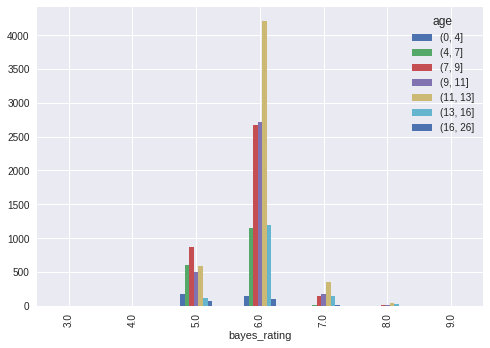

In [0]:
pd.crosstab(age_bins,games['bayes_rating'].round()).T.plot.bar();

In [0]:
pd.crosstab(rating_bins,playtime_bins)

avg_play_time,"(0.779, 45.2]","(45.2, 89.4]","(89.4, 133.6]","(133.6, 177.8]","(177.8, 222.0]"
bayes_rating,,,,,
"(3.46, 3.808]",3,0,0,0,0
"(3.808, 4.151]",1,1,0,0,0
"(4.151, 4.494]",3,1,0,0,1
"(4.494, 4.837]",17,0,0,0,0
"(4.837, 5.18]",29,7,4,0,0
"(5.18, 5.523]",3453,819,671,13,127
"(5.523, 5.867]",4422,1384,1417,67,420
"(5.867, 6.21]",600,288,272,16,71
"(6.21, 6.553]",294,154,158,8,34


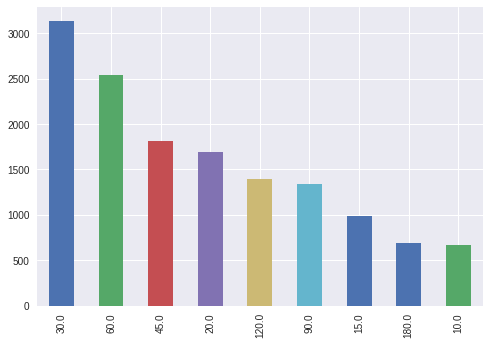

In [0]:
games['avg_play_time'].value_counts()[:10].plot.bar();

In [0]:
pd.crosstab(games['bayes_rating'].round(),games['lang_dependance'],normalize='columns')

lang_dependance,1.0,2.0,3.0,4.0,5.0
bayes_rating,,,,,
3.0,0.000172,0.000000,0.000000,0.000000,0.000000
4.0,0.001204,0.000000,0.001014,0.000000,0.000000
5.0,0.149837,0.142436,0.118094,0.133559,0.302846
6.0,0.784793,0.791403,0.772428,0.753898,0.650407
7.0,0.058834,0.063211,0.099341,0.095593,0.040650
8.0,0.005161,0.002950,0.009123,0.016271,0.006098
9.0,0.000000,0.000000,0.000000,0.000678,0.000000


In [0]:
pd.pivot_table(games, values='rating_votes', 
               columns=games['bayes_rating'].round(), 
               index=games['weight'].round(), fill_value=0)

bayes_rating,3.0,4.0,5.0,6.0,7.0,8.0,9.0
weight,,,,,,,
1.0,2761,3169.625,200.101786,422.617082,9152.386667,29768.000000,0
2.0,0,23371.000,175.539556,408.650724,8604.379205,33867.461538,0
3.0,0,0.000,88.951087,335.365346,5282.046243,21354.314286,0
4.0,0,0.000,150.148148,263.493523,4472.438776,17290.774194,24157
5.0,0,0.000,160.333333,237.735294,1734.250000,3945.000000,0


In [0]:
games[games['weight'] >= 4].describe()

,owned,bayes_rating,weight,avg_play_time,age,best_with_dense,spinoffs,lang_dependance,comment_count,honor_count,publish_date,best_age,max_play_time,min_play_time,play_time_range,max_players,min_players,player_range,rating_votes,weight_votes,trading,wanting,wishing,rating,std_dev
count,326.000000,326.000000,326.000000,313.000000,290.000000,326.000000,326.000000,213.000000,326.000000,326.000000,326.000000,243.000000,311.000000,313.000000,311.000000,322.000000,325.000000,322.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000
mean,1396.567485,5.890114,4.237267,1354.217252,12.693103,2.527607,0.168712,2.737089,238.107362,0.880368,2002.880368,8.078189,1362.540193,600.814696,758.247588,4.819876,1.827692,2.990683,808.806748,85.223926,36.904908,100.392638,434.714724,7.447080,1.655160
std,3215.465552,0.557571,0.222600,7791.748128,1.252936,1.612692,0.858838,1.279882,548.737940,1.704595,13.272799,0.934894,7816.146686,3514.290933,6985.545726,7.784791,0.658165,7.791075,2493.400434,228.498609,88.247625,205.408799,1084.109635,0.792893,0.316816
min,7.000000,5.401420,4.000000,20.000000,9.000000,0.000000,-1.000000,1.000000,1.000000,0.000000,1936.000000,5.000000,20.000000,10.000000,0.000000,1.000000,1.000000,0.000000,30.000000,1.000000,0.000000,0.000000,1.000000,3.596830,0.836193
25%,187.250000,5.569320,4.043450,180.000000,12.000000,2.000000,0.000000,2.000000,32.000000,0.000000,1994.250000,8.000000,180.000000,120.000000,0.000000,2.000000,1.000000,0.000000,56.000000,9.000000,5.000000,13.000000,34.000000,7.014050,1.454450
50%,398.000000,5.644920,4.200000,300.000000,12.000000,2.000000,0.000000,3.000000,65.000000,0.000000,2005.000000,8.000000,300.000000,180.000000,0.000000,4.000000,2.000000,2.000000,124.000000,19.000000,11.000000,32.000000,79.500000,7.487275,1.613400
75%,998.750000,5.936740,4.361975,360.000000,14.000000,4.000000,0.000000,4.000000,160.750000,1.000000,2015.000000,9.000000,360.000000,360.000000,60.000000,6.000000,2.000000,4.000000,325.000000,57.750000,33.750000,74.750000,218.250000,7.993468,1.797958
max,34039.000000,8.258050,5.000000,120000.000000,17.000000,10.000000,6.000000,5.000000,4896.000000,11.000000,2019.000000,11.000000,120000.000000,60000.000000,119880.000000,99.000000,8.000000,98.000000,23305.000000,2100.000000,857.000000,1360.000000,9022.000000,9.230340,3.500490


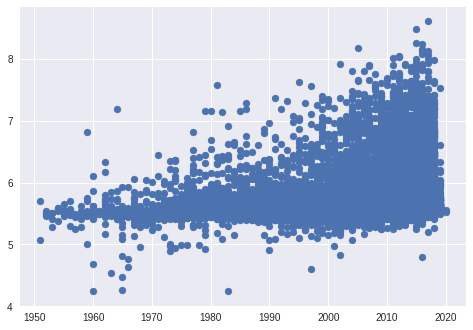

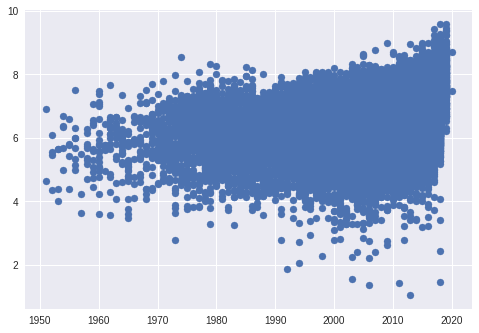

In [0]:
plt.scatter(games[games['publish_date']>1950]['publish_date'], games[games['publish_date']>1950]['bayes_rating']);
plt.show()
plt.scatter(games[games['publish_date']>1950]['publish_date'], games[games['publish_date']>1950]['rating']);

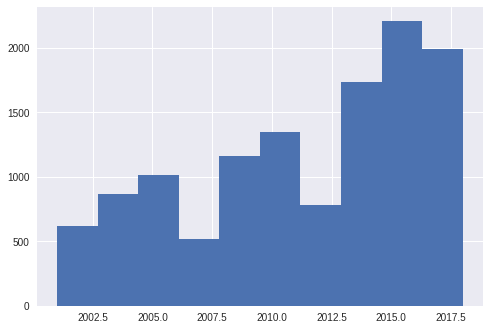

In [0]:
games[(games['publish_date']>2000) & (games['publish_date']<2019)]['publish_date'].hist();

In [0]:
games[(games['publish_date']>2000) & (games['publish_date']<2019)]['publish_date'].value_counts().sort_index()

2001     294
2002     322
2003     395
2004     472
2005     524
2006     494
2007     515
2008     556
2009     602
2010     660
2011     689
2012     780
2013     806
2014     929
2015    1065
2016    1143
2017    1091
2018     899
Name: publish_date, dtype: int64

In [0]:
games[games['publish_date']>1950]['publish_date'].value_counts().sort_index(ascending=False)

2020       2
2019     134
2018     899
2017    1091
2016    1143
2015    1065
2014     929
2013     806
2012     780
2011     689
2010     660
2009     602
2008     556
2007     515
2006     494
2005     524
2004     472
2003     395
2002     322
2001     294
2000     278
1999     262
1998     232
1997     216
1996     203
1995     211
1994     170
1993     173
1992     193
1991     165
1990     139
1989     124
1988     124
1987     126
1986     144
1985     125
1984      91
1983     113
1982     115
1981     144
1980     116
1979     128
1978      90
1977      99
1976      63
1975     113
1974      64
1973      67
1972      67
1971      36
1970      32
1969      25
1968      21
1967      19
1966      11
1965      24
1964      19
1963      14
1962      17
1961      10
1960      20
1959      11
1958       9
1957       3
1956       8
1955       5
1954       5
1953       4
1952       4
1951       2
Name: publish_date, dtype: int64

In [0]:
pd.crosstab(games['bayes_rating'].round(),
            games[(games['publish_date']>2000) & (games['publish_date']<2019)]
            ['publish_date'], normalize='columns')

publish_date,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
bayes_rating,,,,,,,,,,,,,,,,,,
5.0,0.275510,0.257764,0.286076,0.258475,0.263359,0.246964,0.260194,0.179856,0.182724,0.122727,0.136430,0.126923,0.121588,0.107643,0.080751,0.068241,0.034830,0.016685
6.0,0.680272,0.717391,0.683544,0.680085,0.681298,0.714575,0.675728,0.773381,0.744186,0.810606,0.772134,0.787179,0.813896,0.796555,0.830986,0.858268,0.886343,0.931034
7.0,0.044218,0.021739,0.030380,0.059322,0.049618,0.036437,0.058252,0.039568,0.071429,0.062121,0.084180,0.074359,0.059553,0.087191,0.076995,0.064742,0.069661,0.048943
8.0,0.000000,0.003106,0.000000,0.002119,0.005725,0.002024,0.005825,0.007194,0.001661,0.004545,0.007257,0.011538,0.004963,0.008611,0.011268,0.008749,0.008249,0.003337
9.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000917,0.000000


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


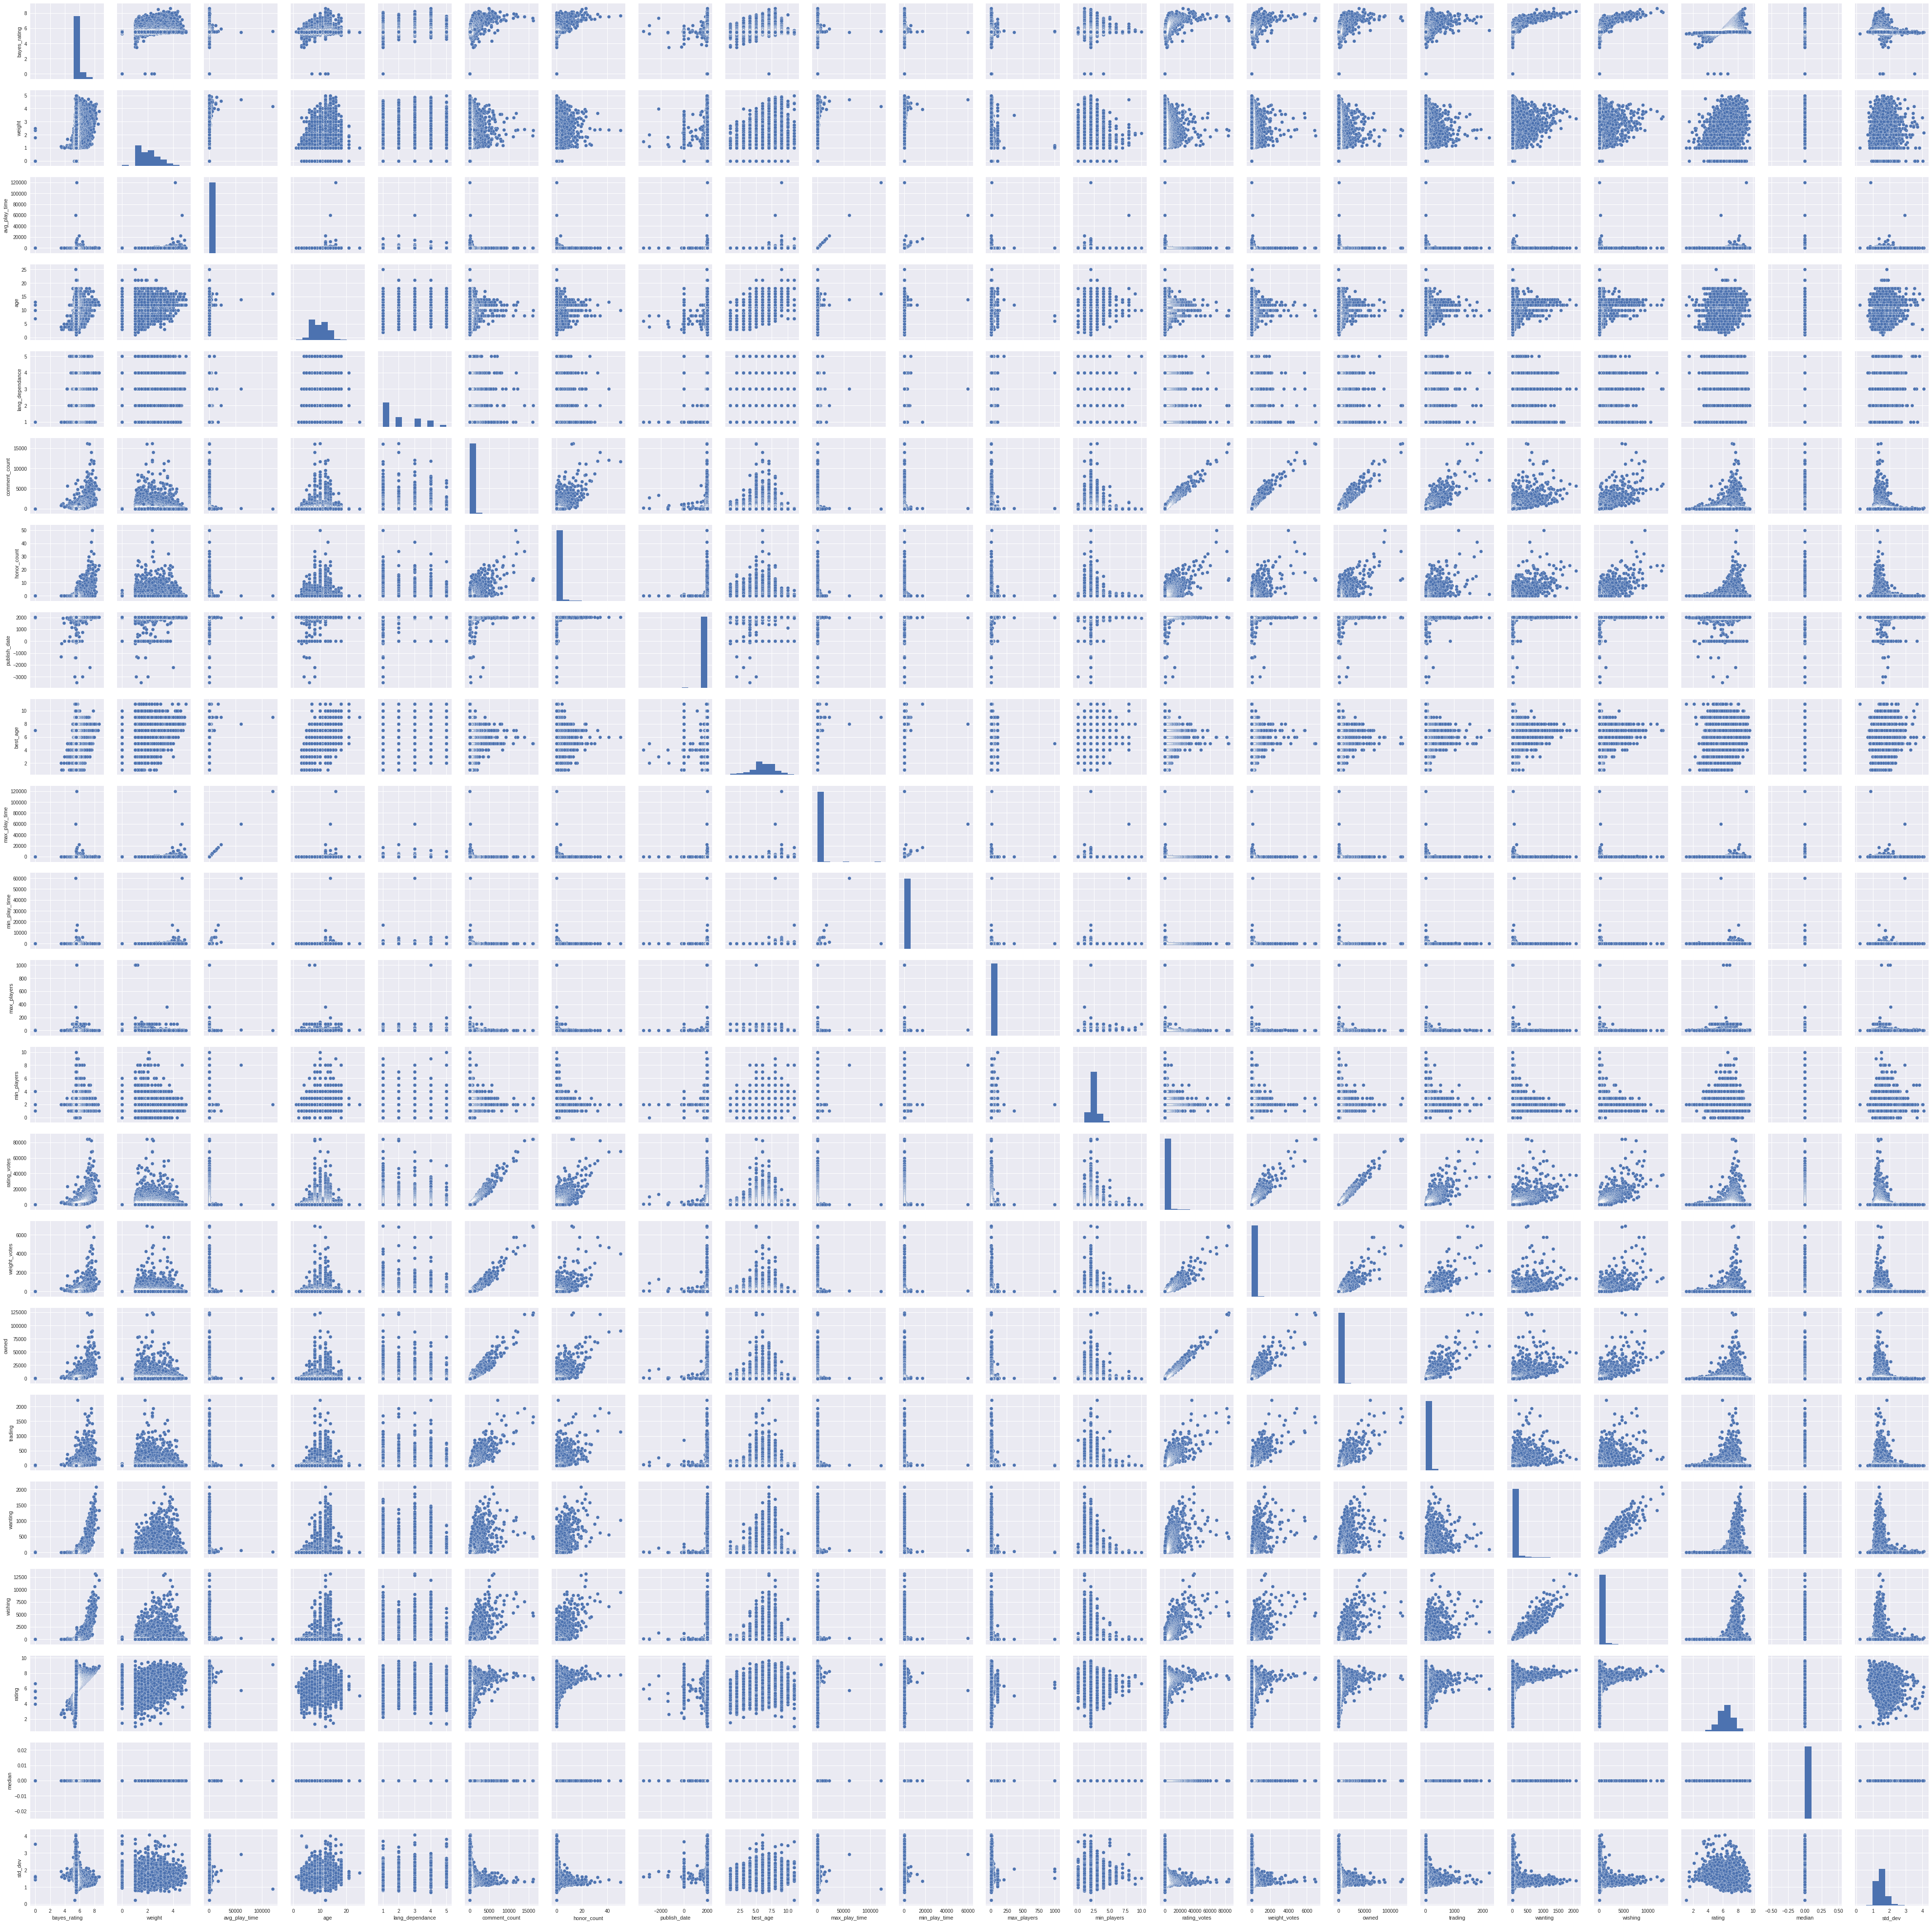

In [0]:
sns.pairplot(games, kind='reg');

###Exploring Owned as a Measure of Popularity

In [0]:
#top 1% of games
most_popular = games.sort_values(by=['owned'],ascending=False).head(172)

In [0]:
most_popular.head()

,name,owned,bayes_rating,weight,avg_play_time,age,best_with_dense,spinoffs,lang_dependance,comment_count,honor_count,publish_date,best_age,max_play_time,min_play_time,play_time_range,max_players,min_players,best_with,player_range,rating_votes,weight_votes,trading,wanting,wishing,rating,std_dev,weight_rnd,description,image
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13,Catan,123608,7.04016,2.3412,120.0,10.0,4,31,2.0,16207,13.0,1995,5.0,120.0,60.0,60.0,4.0,3.0,4.0,1.0,84363,6844,1652,451,4699,7.19430,1.46985,2.0,"In Catan (formerly The Settlers of Catan), pla...",https://cf.geekdo-images.com/original/img/A-0y...
30549,Pandemic,121076,7.54713,2.4230,45.0,8.0,4,8,2.0,13977,34.0,2008,6.0,45.0,45.0,0.0,4.0,2.0,4.0,2.0,82331,4854,1935,622,7610,7.64064,1.32187,2.0,"In Pandemic, several virulent diseases have br...",https://cf.geekdo-images.com/original/img/j-pf...
822,Carcassonne,120110,7.32325,1.9259,45.0,8.0,2,25,1.0,16078,12.0,2000,5.0,45.0,30.0,15.0,5.0,2.0,2.0,3.0,84045,6924,1461,498,5337,7.42741,1.30276,2.0,Carcassonne is a tile-placement game in which ...,https://cf.geekdo-images.com/original/img/o4p6...
68448,7 Wonders,89740,7.69094,2.3406,30.0,10.0,4,1,1.0,11723,50.0,2010,6.0,30.0,30.0,0.0,7.0,2.0,4.0,5.0,68249,3984,1144,1025,9407,7.78348,1.27550,2.0,You are the leader of one of the 7 great citie...,https://cf.geekdo-images.com/original/img/3DP_...
36218,Dominion,87899,7.54537,2.3632,30.0,13.0,3,8,3.0,12115,41.0,2008,6.0,30.0,30.0,0.0,4.0,2.0,3.0,2.0,67698,4669,1791,564,6621,7.64685,1.42680,2.0,(from the back of the box:)<br/><br/>&quot;You...,https://cf.geekdo-images.com/original/img/oN8C...


In [0]:
#top games of the modern era
modern_hits = most_popular[most_popular['publish_date'] > 1990]
modern_hits.describe()

,owned,bayes_rating,weight,avg_play_time,age,best_with_dense,spinoffs,lang_dependance,comment_count,honor_count,publish_date,best_age,max_play_time,min_play_time,play_time_range,max_players,min_players,player_range,rating_votes,weight_votes,trading,wanting,wishing,rating,std_dev,weight_rnd
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.00000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,34629.208861,7.251453,2.361918,74.000000,10.993671,3.873418,2.310127,2.303797,4697.962025,9.93038,2009.044304,6.012658,74.000000,49.886076,24.113924,5.955696,2.037975,3.917722,24866.829114,1443.936709,622.829114,687.537975,4428.658228,7.407132,1.373544,2.335443
std,19579.185575,0.555160,0.836215,59.373373,2.333628,1.295431,5.143671,1.255352,2608.155729,8.26636,6.013091,1.183686,59.373373,32.266994,40.457255,7.961968,0.739134,7.883681,14122.739357,1209.619041,381.838516,442.429290,2600.343485,0.571839,0.178616,0.921165
min,17711.000000,5.576310,1.068500,10.000000,5.000000,1.000000,-1.000000,1.000000,1777.000000,0.00000,1991.000000,3.000000,10.000000,5.000000,0.000000,1.000000,1.000000,0.000000,11165.000000,138.000000,110.000000,38.000000,410.000000,5.683840,1.102910,1.000000
25%,22228.750000,6.936587,1.661925,30.000000,8.000000,3.000000,0.000000,1.000000,2947.750000,4.00000,2005.000000,5.000000,30.000000,30.000000,0.000000,4.000000,2.000000,2.000000,15873.500000,709.500000,343.000000,315.250000,2444.000000,7.065750,1.246590,2.000000
50%,27623.500000,7.286785,2.337850,60.000000,12.000000,4.000000,1.000000,2.000000,3858.500000,8.00000,2011.000000,6.000000,60.000000,45.000000,0.000000,5.000000,2.000000,3.000000,20104.500000,1080.000000,539.000000,595.000000,4215.500000,7.444760,1.355155,2.000000
75%,40505.750000,7.628850,2.999350,90.000000,13.000000,4.000000,2.000000,3.000000,5562.000000,13.00000,2014.000000,7.000000,90.000000,60.000000,30.000000,6.000000,2.000000,4.000000,27930.750000,1766.500000,765.250000,988.000000,6054.250000,7.767710,1.465533,3.000000
max,123608.000000,8.611030,4.364000,360.000000,17.000000,7.000000,34.000000,5.000000,16207.000000,50.00000,2017.000000,9.000000,360.000000,180.000000,240.000000,99.000000,5.000000,97.000000,84363.000000,6924.000000,2223.000000,2080.000000,13136.000000,8.906020,2.070430,4.000000


In [0]:
#all modern games
games[games['publish_date']>1990].describe()

,owned,bayes_rating,weight,avg_play_time,age,best_with_dense,spinoffs,lang_dependance,comment_count,honor_count,publish_date,best_age,max_play_time,min_play_time,play_time_range,max_players,min_players,player_range,rating_votes,weight_votes,trading,wanting,wishing,rating,std_dev,weight_rnd
count,14475.000000,14475.000000,14179.000000,14119.000000,13528.000000,14475.000000,14475.000000,10553.000000,14475.000000,14475.000000,14475.000000,10452.000000,14041.000000,14104.000000,14026.000000,14346.000000,14442.000000,14336.000000,14475.000000,14475.000000,14475.000000,14475.000000,14475.00000,14475.000000,14475.000000,14179.000000
mean,1337.253264,5.724553,2.031304,90.323182,10.238247,2.733955,0.381831,2.056856,210.287461,0.549361,2009.199724,5.693264,90.617050,61.764039,28.762299,5.725777,2.056571,3.674037,826.654093,54.616028,43.905976,47.650777,221.69361,6.436590,1.498422,2.022428
std,4488.362464,0.395955,0.796337,1061.460960,2.735515,1.793900,1.920318,1.219778,637.000156,1.825682,7.188819,1.670968,1064.396256,188.230361,1043.165158,16.730257,0.674646,16.697100,3227.962129,217.576682,97.308105,127.325294,680.85157,0.905562,0.283940,0.857158
min,3.000000,4.603830,1.000000,1.000000,1.000000,0.000000,-1.000000,1.000000,1.000000,0.000000,1991.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,30.000000,0.000000,0.000000,0.000000,0.00000,1.052540,0.219673,1.000000
25%,144.000000,5.516610,1.357100,30.000000,8.000000,2.000000,0.000000,1.000000,24.000000,0.000000,2005.000000,5.000000,30.000000,20.000000,0.000000,4.000000,2.000000,2.000000,56.000000,4.000000,5.000000,3.000000,14.00000,5.864590,1.301865,1.000000
50%,308.000000,5.565520,2.000000,45.000000,10.000000,3.000000,0.000000,2.000000,50.000000,0.000000,2011.000000,6.000000,45.000000,30.000000,0.000000,4.000000,2.000000,2.000000,125.000000,10.000000,14.000000,10.000000,41.00000,6.463330,1.455740,2.000000
75%,865.500000,5.738265,2.555600,90.000000,12.000000,4.000000,0.000000,3.000000,138.000000,0.000000,2015.000000,7.000000,90.000000,60.000000,10.000000,6.000000,2.000000,4.000000,404.000000,29.000000,41.000000,33.000000,135.00000,7.042875,1.641395,3.000000
max,123608.000000,8.611030,5.000000,120000.000000,25.000000,18.000000,34.000000,5.000000,16207.000000,50.000000,2020.000000,11.000000,120000.000000,17280.000000,119880.000000,999.000000,9.000000,997.000000,84363.000000,6924.000000,2223.000000,2080.000000,13136.00000,9.597140,4.068800,5.000000


In [0]:
sns.pairplot(modern_hits)

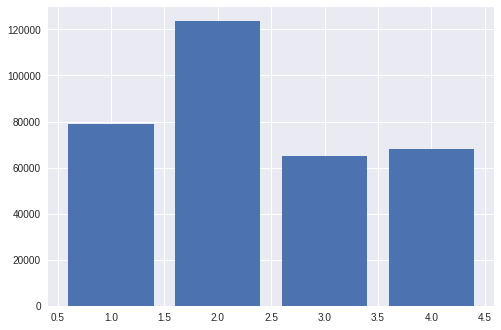

In [0]:
plt.bar(modern_hits['weight_rnd'],modern_hits['owned']);

In [0]:
modern_hits.groupby('publish_date')['owned'].sum()

publish_date
1991     17837
1993     30342
1994     45352
1995    143859
1996     19650
1997    120979
1998     24755
1999     85183
2000    223688
2001    113392
2002     92244
2003     71749
2004    314855
2005    267430
2006     41255
2007    180803
2008    452829
2009    247534
2010    247098
2011    440059
2012    671321
2013    231626
2014    545079
2015    410061
2016    332257
2017    100178
Name: owned, dtype: int64

In [0]:
modern_hits['publish_date'].value_counts().sort_index()

1991     1
1993     1
1994     2
1995     2
1996     1
1997     4
1998     1
1999     3
2000     4
2001     3
2002     2
2003     3
2004     8
2005     8
2006     2
2007     5
2008    10
2009     6
2010     5
2011    14
2012    21
2013     8
2014    18
2015    12
2016    11
2017     3
Name: publish_date, dtype: int64

In [0]:
(modern_hits.groupby('publish_date')['owned'].sum())/(modern_hits['publish_date'].value_counts())

1991    17837.000000
1993    30342.000000
1994    22676.000000
1995    71929.500000
1996    19650.000000
1997    30244.750000
1998    24755.000000
1999    28394.333333
2000    55922.000000
2001    37797.333333
2002    46122.000000
2003    23916.333333
2004    39356.875000
2005    33428.750000
2006    20627.500000
2007    36160.600000
2008    45282.900000
2009    41255.666667
2010    49419.600000
2011    31432.785714
2012    31967.666667
2013    28953.250000
2014    30282.166667
2015    34171.750000
2016    30205.181818
2017    33392.666667
dtype: float64

In [0]:
modern_hits['best_with_dense'].value_counts().sort_index()

1     3
2    25
3    22
4    71
5    17
6    16
7     4
Name: best_with_dense, dtype: int64

In [0]:
modern_hits['max_players'].value_counts().sort_index()

1.0      1
2.0     13
4.0     53
5.0     36
6.0     23
7.0      7
8.0     14
10.0     7
12.0     2
30.0     1
99.0     1
Name: max_players, dtype: int64

In [0]:
modern_hits.groupby('best_with_dense')['weight'].mean()

best_with_dense
1    2.935133
2    2.467416
3    2.731145
4    2.407524
5    2.193453
6    1.751019
7    1.591975
Name: weight, dtype: float64

In [0]:
games.groupby('best_with_dense')['weight'].mean()

best_with_dense
0     1.845780
1     2.205615
2     2.318961
3     1.994807
4     1.967597
5     1.940298
6     1.706779
7     1.843062
8     1.617542
9     1.659178
10    1.712039
11    1.333350
12    1.466550
13    1.559333
14    1.843500
15    1.755760
16    1.522000
18    1.000000
31    2.071400
Name: weight, dtype: float64

In [0]:
modern_hits.groupby('age')['weight'].mean()

age
5.0     1.782600
6.0     1.642300
7.0     1.867850
8.0     1.683900
9.0     2.337800
10.0    2.044481
12.0    2.864421
13.0    2.524948
14.0    3.156635
15.0    1.619900
17.0    1.220500
Name: weight, dtype: float64

In [0]:
games.groupby('age')['weight'].mean()

age
1.0     1.000000
2.0     1.027778
3.0     1.104311
4.0     1.105442
5.0     1.173085
6.0     1.282775
7.0     1.382915
8.0     1.594405
9.0     1.799621
10.0    1.967432
11.0    2.197506
12.0    2.600305
13.0    2.264590
14.0    2.570885
15.0    2.213847
16.0    2.282664
17.0    1.694518
18.0    1.556566
21.0    1.834286
25.0    1.000000
Name: weight, dtype: float64

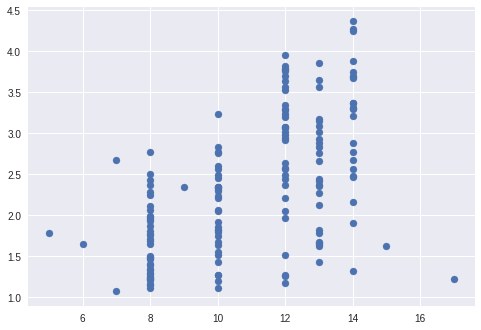

In [0]:
plt.scatter(modern_hits['age'],modern_hits['weight']);

In [0]:
modern_hits['age'].value_counts().sort_index()

5.0      1
6.0      1
7.0      2
8.0     37
9.0      1
10.0    32
12.0    34
13.0    25
14.0    23
15.0     1
17.0     1
Name: age, dtype: int64

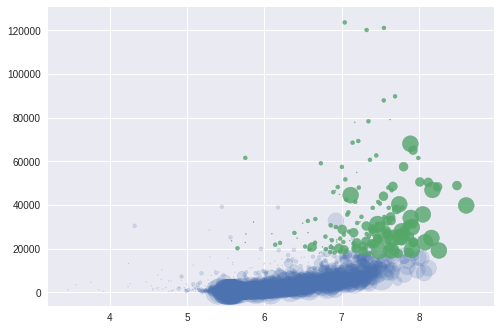

In [0]:
plt.scatter(x=games['bayes_rating'],y=games['owned'],s=games['weight_rnd']**4, alpha=.2)
plt.scatter(x=modern_hits['bayes_rating'],y=modern_hits['owned'],s=modern_hits['weight_rnd']**4,alpha=.75);

##Ancillary Datasets: Explore and Feature Engineer

###Functions

In [0]:
def get_csv(csv):
  df = pd.read_csv(csv)
  
  df = df.drop('Unnamed: 0',axis='columns')
  df = df.rename(columns={'Unnamed: 0.1':'id'})
  df = df.set_index('id')
  return df

In [0]:
def support_variables(df):
  general_items = df.notnull().sum().sort_values(ascending=False)
  items_by_game = df.T
  items_count = items_by_game.describe().T['count']
  return general_items, items_by_game, items_count.astype(int)

In [0]:
def popular_items(items_by_game):
  popular_items = pd.Series()
  for id in modern_hits.index:
    popular_items = popular_items.append(items_by_game[items_by_game[id]
                                                            .notnull()][id])
  popular_items = popular_items.index.value_counts()
  return popular_items

In [0]:
def counts(general_items,popular_items):
  counts = pd.DataFrame((general_items/len(games)))
  counts['pop_count'] = (popular_items/len(modern_hits))
  counts = counts.rename(columns={0:'gen_count'})
  return counts.sort_values(by='pop_count', ascending=False)  

###Mechanics

In [0]:
mechanics = get_csv('mechanics_all.csv')
general_mechanics, mech_by_game, games['mechanic_count'] = support_variables(mechanics)
popular_mechanics = popular_items(mech_by_game)
counts(general_mechanics,popular_mechanics).head(10)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (15,21,36) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,gen_count,pop_count
Hand Management,0.201421,0.506329
Variable Player Powers,0.118068,0.367089
Dice Rolling,0.228798,0.322785
Set Collection,0.130126,0.284810
Card Drafting,0.082537,0.265823
Cooperative Play,0.058656,0.202532
Tile Placement,0.082188,0.164557
Modular Board,0.077528,0.164557
Simultaneous Action Selection,0.055044,0.145570
Grid Movement,0.041414,0.132911


###Designers

In [0]:
designers = get_csv('designers_all.csv')
general_designers, designers_by_game, games['designer_count'] = support_variables(designers)
popular_designers = popular_items(designers_by_game)
counts(general_designers,popular_designers).head(10)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (3,4,5,7,9,10,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,34,36,37,38,39,41,42,43,44,46,47,48,49,50,51,53,54,56,57,58,59,61,63,64,65,66,67,68,69,70,71,75,76,77,79,80,82,85,86,87,88,90,91,92,93,95,96,97,99,101,102,103,109,110,112,113,114,115,116,117,118,119,120,121,123,124,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,147,149,150,151,152,153,155,156,157,158,161,162,164,165,166,167,168,169,170,171,172,173,175,177,178,180,181,182,185,186,187,189,192,193,194,195,196,197,198,200,201,202,203,204,205,207,208,209,211,213,214,215,217,218,220,222,223,225,226,227,229,230,231,232,233,234,237,241,242,243,244,245,246,249,250,251,252,253,256,257,259,260,261,262,264,265,266,267,268,269,270,271,272,273,274,276,278,279,280,283,284,285,286,287,288,289,291,292,294,295,296,297,299,300,301,302,303,305,306,307,308,309,310,311,312,314,315,316,317,319,320,321,323

,gen_count,pop_count
Vlaada Chvátil,0.001689,0.037975
Corey Konieczka,0.001398,0.037975
Antoine Bauza,0.001980,0.037975
Bruno Cathala,0.004019,0.031646
Richard Garfield,0.001631,0.031646
Uwe Rosenberg,0.002854,0.031646
Matt Leacock,0.000990,0.025316
Kevin Wilson,0.001864,0.025316
Andreas Seyfarth,0.000524,0.018987
Donald X. Vaccarino,0.000932,0.018987


###Artists

In [0]:
artists = get_csv('artists_all.csv')
general_artists, artists_by_game, games['artist_count'] = support_variables(artists)
popular_artists = popular_items(artists_by_game)
counts(general_artists,popular_artists).head(10)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (1,2,5,6,9,12,13,14,21,23,26,28,30,31,32,34,37,41,43,46,47,51,52,53,54,57,60,63,64,65,66,67,69,70,71,72,74,77,80,82,83,88,89,90,91,94,97,99,101,102,104,106,108,109,111,112,114,117,118,119,121,130,134,135,139,141,144,145,146,147,149,151,152,153,154,155,156,157,159,160,161,162,163,165,166,167,168,169,170,171,173,174,175,177,181,182,183,184,185,187,188,190,191,192,195,197,199,200,201,202,203,206,207,209,211,213,214,215,216,217,219,221,222,229,232,235,237,238,239,241,242,243,245,246,247,251,253,257,260,261,263,264,269,270,271,273,274,276,278,279,282,283,284,286,289,291,300,308,311,312,315,316,318,321,322,323,325,326,329,331,333,334,335,337,338,339,341,342,345,347,349,352,353,357,359,360,361,362,363,364,370,374,376,378,379,380,382,383,384,385,386,388,391,392,393,394,396,398,399,400,404,406,407,409,410,411,415,416,421,428,429,432,435,436,437,438,442,443,444,447,448,449,450,451,453,454,455,456,

,gen_count,pop_count
Franz Vohwinkel,0.012523,0.082278
Henning Ludvigsen,0.002039,0.063291
Harald Lieske,0.005184,0.050633
Klemens Franz,0.005126,0.050633
Julien Delval,0.002388,0.050633
Michael Menzel,0.006466,0.037975
Claus Stephan,0.005068,0.037975
Chris Quilliams,0.002272,0.037975
Cyrille Daujean,0.001980,0.037975
Dennis Lohausen,0.003553,0.037975


###Categories

In [0]:
categories = get_csv('categories_all.csv')
general_categories, categories_by_game, games['category_count'] = support_variables(categories)
popular_categories = popular_items(categories_by_game)
counts(general_categories,popular_categories).head(10)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (37) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,gen_count,pop_count
Card Game,0.288793,0.348101
Fantasy,0.117486,0.227848
Fighting,0.077528,0.189873
Adventure,0.050384,0.151899
Economic,0.072519,0.151899
Science Fiction,0.077586,0.151899
Bluffing,0.058889,0.113924
Party Game,0.084751,0.113924
Deduction,0.049569,0.107595
Medieval,0.048521,0.107595


###Subdomains

In [0]:
subdomains = get_csv('subdomains_all.csv')
general_subdomains, subdomains_by_game, games['subdomain_count'] = support_variables(subdomains)
popular_subdomains = popular_items(subdomains_by_game)
counts(general_subdomains,popular_subdomains).head(10)

,gen_count,pop_count
Strategy Games,0.111370,0.417722
Family Games,0.105312,0.348101
Thematic Games,0.060345,0.227848
Party Games,0.030231,0.120253
Abstract Games,0.055801,0.056962
Customizable Games,0.016368,0.031646
Wargames,0.171890,0.018987
Children's Games,0.044443,NaN


###Publishers

In [0]:
publishers = get_csv('publishers_all.csv')
general_publishers, publishers_by_game, games['publisher_count'] = support_variables(publishers)
popular_publishers = popular_items(publishers_by_game)
counts(general_publishers,popular_publishers).head(10)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252

,gen_count,pop_count
Kaissa Chess & Games,0.014504,0.316456
Devir,0.017766,0.297468
Hobby World,0.017649,0.297468
Edge Entertainment,0.021901,0.272152
Rebel,0.015261,0.265823
"Korea Boardgames co., Ltd.",0.009844,0.253165
Asmodee,0.025221,0.246835
Galápagos Jogos,0.006466,0.240506
"Swan Panasia Co., Ltd.",0.014562,0.234177
Lautapelit.fi,0.010019,0.234177


###Save for Time

In [0]:
games.to_csv('games_all_engineered.csv')

##Break

In [0]:
def size_by_perc(percent, population):
  return int(len(population)*percent)

In [0]:
#reassign so they are updated with the new features
modern_games = games[games['publish_date']>1990]
modern_hits = modern_games.sort_values(by=['owned'],ascending=False).head(size_by_perc(.05,modern_games))
top_rated_games = modern_games.sort_values(by=['bayes_rating'],ascending=False).head(size_by_perc(.05,modern_games))

In [0]:
modern_games.describe()

,owned,bayes_rating,weight,avg_play_time,age,best_with_dense,spinoffs,lang_dependance,comment_count,honor_count,publish_date,best_age,max_play_time,min_play_time,play_time_range,max_players,min_players,player_range,rating_votes,weight_votes,trading,wanting,wishing,rating,std_dev,weight_rnd,mechanic_count,designer_count,artist_count,category_count,subdomain_count,publisher_count
count,14475.000000,14475.000000,14179.000000,14119.000000,13528.000000,14475.000000,14475.000000,10553.000000,14475.000000,14475.000000,14475.000000,10452.000000,14041.000000,14104.000000,14026.000000,14346.000000,14442.000000,14336.000000,14475.000000,14475.000000,14475.000000,14475.000000,14475.00000,14475.000000,14475.000000,14179.000000,14475.000000,10947.000000,5125.000000,14475.000000,14475.000000,14475.000000
mean,1337.253264,5.724553,2.031304,90.323182,10.238247,2.733955,0.381831,2.056856,210.287461,0.549361,2009.199724,5.693264,90.617050,61.764039,28.762299,5.725777,2.056571,3.674037,826.654093,54.616028,43.905976,47.650777,221.69361,6.436590,1.498422,2.022428,2.399447,1.376359,2.192195,2.630259,0.567737,2.230397
std,4488.362464,0.395955,0.796337,1061.460960,2.735515,1.793900,1.920318,1.219778,637.000156,1.825682,7.188819,1.670968,1064.396256,188.230361,1043.165158,16.730257,0.674646,16.697100,3227.962129,217.576682,97.308105,127.325294,680.85157,0.905562,0.283940,0.857158,1.649266,0.817954,8.425081,1.380472,0.634132,2.451162
min,3.000000,4.603830,1.000000,1.000000,1.000000,0.000000,-1.000000,1.000000,1.000000,0.000000,1991.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,30.000000,0.000000,0.000000,0.000000,0.00000,1.052540,0.219673,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,144.000000,5.516610,1.357100,30.000000,8.000000,2.000000,0.000000,1.000000,24.000000,0.000000,2005.000000,5.000000,30.000000,20.000000,0.000000,4.000000,2.000000,2.000000,56.000000,4.000000,5.000000,3.000000,14.00000,5.864590,1.301865,1.000000,1.000000,1.000000,1.000000,2.000000,0.000000,1.000000
50%,308.000000,5.565520,2.000000,45.000000,10.000000,3.000000,0.000000,2.000000,50.000000,0.000000,2011.000000,6.000000,45.000000,30.000000,0.000000,4.000000,2.000000,2.000000,125.000000,10.000000,14.000000,10.000000,41.00000,6.463330,1.455740,2.000000,2.000000,1.000000,1.000000,2.000000,0.000000,1.000000
75%,865.500000,5.738265,2.555600,90.000000,12.000000,4.000000,0.000000,3.000000,138.000000,0.000000,2015.000000,7.000000,90.000000,60.000000,10.000000,6.000000,2.000000,4.000000,404.000000,29.000000,41.000000,33.000000,135.00000,7.042875,1.641395,3.000000,3.000000,2.000000,2.000000,3.000000,1.000000,2.000000
max,123608.000000,8.611030,5.000000,120000.000000,25.000000,18.000000,34.000000,5.000000,16207.000000,50.000000,2020.000000,11.000000,120000.000000,17280.000000,119880.000000,999.000000,9.000000,997.000000,84363.000000,6924.000000,2223.000000,2080.000000,13136.00000,9.597140,4.068800,5.000000,18.000000,12.000000,509.000000,13.000000,3.000000,41.000000


In [53]:
modern_hits.describe()

,owned,bayes_rating,weight,avg_play_time,age,best_with_dense,spinoffs,lang_dependance,comment_count,honor_count,publish_date,best_age,max_play_time,min_play_time,play_time_range,max_players,min_players,player_range,rating_votes,weight_votes,trading,wanting,wishing,rating,std_dev,weight_rnd,mechanic_count,designer_count,artist_count,category_count,subdomain_count,publisher_count
count,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,722.000000,722.000000,723.000000,722.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000
mean,14576.554633,6.927287,2.382605,77.304288,11.161826,3.622407,1.199170,2.284924,2118.842324,4.952974,2010.193638,6.074792,77.328255,55.343015,21.991690,5.354080,1.970954,3.383126,10191.305671,603.366528,321.578147,424.408022,2271.791148,7.245876,1.357623,2.373444,3.954357,1.484094,3.914246,3.294606,1.230982,8.138313
std,14296.074089,0.503473,0.782473,67.536315,2.380108,1.402371,3.482707,1.227177,1937.849654,5.527870,6.024522,1.209051,67.580057,41.569335,49.905124,6.909121,0.702577,6.849477,10509.760999,765.963870,269.809290,344.697568,1988.099472,0.537839,0.174665,0.856109,1.815406,0.850751,19.619111,1.611184,0.428270,5.565297
min,5121.000000,5.272000,1.023300,2.000000,4.000000,1.000000,-1.000000,1.000000,184.000000,0.000000,1991.000000,1.000000,2.000000,2.000000,0.000000,1.000000,1.000000,0.000000,1367.000000,13.000000,21.000000,7.000000,85.000000,5.218980,1.047930,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,6790.500000,6.611760,1.778550,30.000000,10.000000,3.000000,0.000000,1.000000,961.500000,1.000000,2007.000000,5.000000,30.000000,30.000000,0.000000,4.000000,2.000000,2.000000,4293.500000,167.000000,151.000000,168.000000,911.500000,6.921060,1.227255,2.000000,3.000000,1.000000,1.000000,2.000000,1.000000,4.000000
50%,9357.000000,6.934520,2.330500,60.000000,12.000000,4.000000,0.000000,2.000000,1503.000000,3.000000,2012.000000,6.000000,60.000000,45.000000,0.000000,4.000000,2.000000,3.000000,6566.000000,373.000000,249.000000,323.000000,1658.000000,7.269000,1.326840,2.000000,4.000000,1.000000,2.000000,3.000000,1.000000,7.000000
75%,16242.500000,7.258050,2.909750,100.000000,13.000000,4.000000,1.000000,3.000000,2547.500000,7.000000,2015.000000,7.000000,100.000000,60.000000,30.000000,6.000000,2.000000,4.000000,11889.500000,724.500000,399.500000,589.500000,2918.000000,7.596670,1.468740,3.000000,5.000000,2.000000,3.000000,4.000000,1.000000,11.000000
max,123608.000000,8.611030,4.516100,1000.000000,18.000000,15.000000,34.000000,5.000000,16207.000000,50.000000,2019.000000,10.000000,1000.000000,480.000000,995.000000,100.000000,8.000000,99.000000,84363.000000,6924.000000,2223.000000,2080.000000,13136.000000,8.906020,2.123380,5.000000,11.000000,8.000000,509.000000,9.000000,2.000000,41.000000


In [0]:
modern_hits[modern_hits['artist_count'] != 509].describe()

,owned,bayes_rating,weight,avg_play_time,age,best_with_dense,spinoffs,lang_dependance,comment_count,honor_count,publish_date,best_age,max_play_time,min_play_time,play_time_range,max_players,min_players,player_range,rating_votes,weight_votes,trading,wanting,wishing,rating,std_dev,weight_rnd,mechanic_count,designer_count,artist_count,category_count,subdomain_count,publisher_count
count,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.00000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000
mean,34656.515924,7.251026,2.356761,74.343949,10.980892,3.885350,2.254777,2.286624,4687.363057,9.929936,2009.146497,6.006369,74.343949,50.076433,24.267516,5.980892,2.038217,3.942675,24848.828025,1441.146497,621.936306,690.687898,4453.662420,7.406711,1.370539,2.33121,4.343949,1.433121,4.496815,3.464968,1.222930,13.025478
std,19638.820545,0.556910,0.836366,59.405248,2.335543,1.290836,5.112710,1.240611,2613.086053,8.292810,5.893081,1.184823,59.405248,32.281125,40.540480,7.981125,0.741493,7.902646,14166.113705,1212.979642,382.894922,442.064154,2589.539471,0.573645,0.175135,0.92257,1.989438,0.893523,7.101484,1.571088,0.417544,7.012762
min,17711.000000,5.576310,1.068500,10.000000,5.000000,1.000000,-1.000000,1.000000,1777.000000,0.000000,1991.000000,3.000000,10.000000,5.000000,0.000000,1.000000,1.000000,0.000000,11165.000000,138.000000,110.000000,38.000000,410.000000,5.683840,1.102910,1.00000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,22194.000000,6.936070,1.660000,30.000000,8.000000,3.000000,0.000000,1.000000,2947.000000,4.000000,2005.000000,5.000000,30.000000,30.000000,0.000000,4.000000,2.000000,2.000000,15862.000000,709.000000,342.000000,316.000000,2453.000000,7.064820,1.246060,2.00000,3.000000,1.000000,1.000000,2.000000,1.000000,8.000000
50%,27549.000000,7.280580,2.337800,60.000000,12.000000,4.000000,1.000000,2.000000,3855.000000,8.000000,2011.000000,6.000000,60.000000,45.000000,0.000000,5.000000,2.000000,3.000000,19817.000000,1078.000000,537.000000,602.000000,4249.000000,7.441200,1.355090,2.00000,4.000000,1.000000,3.000000,3.000000,1.000000,13.000000
75%,40579.000000,7.629280,2.976100,90.000000,13.000000,4.000000,2.000000,3.000000,5553.000000,13.000000,2014.000000,7.000000,90.000000,60.000000,30.000000,6.000000,2.000000,4.000000,28010.000000,1765.000000,766.000000,994.000000,6070.000000,7.767820,1.459750,3.00000,5.000000,2.000000,5.000000,4.000000,1.000000,17.000000
max,123608.000000,8.611030,4.364000,360.000000,17.000000,7.000000,34.000000,5.000000,16207.000000,50.000000,2017.000000,9.000000,360.000000,180.000000,240.000000,99.000000,5.000000,97.000000,84363.000000,6924.000000,2223.000000,2080.000000,13136.000000,8.906020,2.070430,4.00000,11.000000,8.000000,62.000000,8.000000,2.000000,41.000000


In [0]:
games[games['artist_count'] != 509].describe()

,owned,bayes_rating,weight,avg_play_time,age,best_with_dense,spinoffs,lang_dependance,comment_count,honor_count,publish_date,best_age,max_play_time,min_play_time,play_time_range,max_players,min_players,player_range,rating_votes,weight_votes,trading,wanting,wishing,rating,std_dev,weight_rnd,mechanic_count,designer_count,artist_count,category_count,subdomain_count,publisher_count
count,17167.000000,17167.000000,16856.000000,16734.000000,16042.000000,17167.000000,17167.000000,12125.000000,17167.000000,17167.000000,17167.000000,12182.000000,16656.000000,16719.000000,16641.000000,16986.000000,17101.000000,16976.000000,17167.000000,17167.000000,17167.000000,17167.000000,17167.000000,17167.000000,17167.000000,16856.000000,17167.000000,12839.000000,5807.000000,17167.000000,17167.000000,17167.000000
mean,1252.493330,5.700638,2.045161,99.708378,10.203840,2.670647,0.506379,2.048082,202.189084,0.492864,1983.909594,5.702184,100.000060,72.401160,27.481041,5.601613,2.048184,3.557316,766.302149,52.679618,42.058950,42.766296,195.263529,6.362155,1.507223,2.034824,2.291082,1.375185,2.110901,2.584668,0.595620,2.592707
std,4228.944223,0.381495,0.802970,1093.507838,2.721669,1.806590,2.503534,1.221068,607.212498,1.695799,207.201972,1.714580,1096.055664,509.504948,963.451381,15.832608,0.667644,15.797918,3026.283295,205.553919,93.296943,118.735397,632.703961,0.917306,0.277474,0.863051,1.607945,0.816261,4.514007,1.357051,0.629149,5.345383
min,3.000000,3.465090,1.000000,1.000000,1.000000,0.000000,-1.000000,1.000000,1.000000,0.000000,-3500.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,30.000000,0.000000,0.000000,0.000000,0.000000,1.052540,0.219673,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,143.000000,5.511825,1.368400,30.000000,8.000000,2.000000,0.000000,1.000000,24.000000,0.000000,1999.000000,5.000000,30.000000,20.000000,0.000000,4.000000,2.000000,1.000000,55.000000,5.000000,5.000000,3.000000,12.000000,5.785385,1.316900,1.000000,1.000000,1.000000,1.000000,2.000000,0.000000,1.000000
50%,298.000000,5.556930,2.000000,45.000000,10.000000,2.000000,0.000000,2.000000,50.000000,0.000000,2009.000000,6.000000,45.000000,40.000000,0.000000,4.000000,2.000000,2.000000,118.000000,10.000000,14.000000,9.000000,34.000000,6.392760,1.470570,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000
75%,804.000000,5.706850,2.581275,90.000000,12.000000,4.000000,0.000000,3.000000,133.000000,0.000000,2015.000000,7.000000,90.000000,60.000000,0.000000,6.000000,2.000000,4.000000,370.500000,29.000000,39.000000,29.000000,113.000000,6.971095,1.649245,3.000000,3.000000,2.000000,2.000000,3.000000,1.000000,2.000000
max,123608.000000,8.611030,5.000000,120000.000000,25.000000,31.000000,123.000000,5.000000,16207.000000,50.000000,2020.000000,11.000000,120000.000000,60000.000000,119880.000000,999.000000,10.000000,997.000000,84363.000000,6924.000000,2223.000000,2080.000000,13136.000000,9.597140,4.068800,5.000000,18.000000,12.000000,146.000000,14.000000,3.000000,174.000000


In [54]:
top_rated_games.describe()

,owned,bayes_rating,weight,avg_play_time,age,best_with_dense,spinoffs,lang_dependance,comment_count,honor_count,publish_date,best_age,max_play_time,min_play_time,play_time_range,max_players,min_players,player_range,rating_votes,weight_votes,trading,wanting,wishing,rating,std_dev,weight_rnd,mechanic_count,designer_count,artist_count,category_count,subdomain_count,publisher_count
count,723.000000,723.000000,723.000000,723.000000,718.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,722.000000,723.000000,722.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000
mean,13097.351314,7.070450,2.658152,92.197787,11.571031,3.500692,0.863071,2.298755,1928.522822,4.973721,2011.255878,6.337483,92.242382,65.266943,26.968144,4.849239,1.917012,2.932227,9355.778700,549.706777,260.156293,468.060858,2371.514523,7.517544,1.341472,2.656985,4.005533,1.524205,3.619640,3.152144,1.211618,7.136929
std,14630.823598,0.345459,0.750754,72.814898,2.140751,1.264664,2.729607,1.221613,1972.283676,5.483860,5.505935,1.127382,72.855495,49.443629,53.191282,5.317687,0.637060,5.330579,10722.911435,770.664186,260.069742,319.450410,1921.427357,0.375151,0.157476,0.822916,1.808712,0.896536,19.309206,1.584754,0.412113,5.455872
min,1104.000000,6.632430,1.026500,10.000000,5.000000,1.000000,-1.000000,1.000000,253.000000,0.000000,1991.000000,2.000000,10.000000,5.000000,0.000000,1.000000,1.000000,0.000000,1037.000000,15.000000,14.000000,32.000000,113.000000,6.731090,1.047930,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4917.000000,6.810085,2.155150,45.000000,10.000000,2.000000,0.000000,1.000000,752.500000,1.000000,2009.000000,5.000000,45.000000,30.000000,0.000000,4.000000,2.000000,2.000000,3319.500000,134.000000,101.000000,241.000000,1087.000000,7.235535,1.221200,2.000000,3.000000,1.000000,1.000000,2.000000,1.000000,3.000000
50%,8127.000000,6.986450,2.667200,75.000000,12.000000,4.000000,0.000000,2.000000,1259.000000,4.000000,2013.000000,6.000000,77.500000,60.000000,10.000000,4.000000,2.000000,3.000000,5678.000000,296.000000,175.000000,381.000000,1767.000000,7.455130,1.316720,3.000000,4.000000,1.000000,2.000000,3.000000,1.000000,6.000000
75%,15354.500000,7.269370,3.199050,120.000000,13.000000,4.000000,1.000000,3.000000,2345.500000,7.000000,2015.000000,7.000000,120.000000,90.000000,30.000000,5.000000,2.000000,3.000000,10977.000000,663.000000,324.000000,605.500000,2921.500000,7.755300,1.445140,3.000000,5.000000,2.000000,3.000000,4.000000,1.000000,10.000000
max,123608.000000,8.611030,4.548600,1000.000000,18.000000,12.000000,31.000000,5.000000,16207.000000,50.000000,2019.000000,10.000000,1000.000000,480.000000,995.000000,100.000000,5.000000,99.000000,84363.000000,6924.000000,1935.000000,2080.000000,13136.000000,8.906020,2.131660,5.000000,11.000000,8.000000,509.000000,8.000000,2.000000,41.000000


In [55]:
modern_hits.describe()

,owned,bayes_rating,weight,avg_play_time,age,best_with_dense,spinoffs,lang_dependance,comment_count,honor_count,publish_date,best_age,max_play_time,min_play_time,play_time_range,max_players,min_players,player_range,rating_votes,weight_votes,trading,wanting,wishing,rating,std_dev,weight_rnd,mechanic_count,designer_count,artist_count,category_count,subdomain_count,publisher_count
count,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,722.000000,722.000000,723.000000,722.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000
mean,14576.554633,6.927287,2.382605,77.304288,11.161826,3.622407,1.199170,2.284924,2118.842324,4.952974,2010.193638,6.074792,77.328255,55.343015,21.991690,5.354080,1.970954,3.383126,10191.305671,603.366528,321.578147,424.408022,2271.791148,7.245876,1.357623,2.373444,3.954357,1.484094,3.914246,3.294606,1.230982,8.138313
std,14296.074089,0.503473,0.782473,67.536315,2.380108,1.402371,3.482707,1.227177,1937.849654,5.527870,6.024522,1.209051,67.580057,41.569335,49.905124,6.909121,0.702577,6.849477,10509.760999,765.963870,269.809290,344.697568,1988.099472,0.537839,0.174665,0.856109,1.815406,0.850751,19.619111,1.611184,0.428270,5.565297
min,5121.000000,5.272000,1.023300,2.000000,4.000000,1.000000,-1.000000,1.000000,184.000000,0.000000,1991.000000,1.000000,2.000000,2.000000,0.000000,1.000000,1.000000,0.000000,1367.000000,13.000000,21.000000,7.000000,85.000000,5.218980,1.047930,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,6790.500000,6.611760,1.778550,30.000000,10.000000,3.000000,0.000000,1.000000,961.500000,1.000000,2007.000000,5.000000,30.000000,30.000000,0.000000,4.000000,2.000000,2.000000,4293.500000,167.000000,151.000000,168.000000,911.500000,6.921060,1.227255,2.000000,3.000000,1.000000,1.000000,2.000000,1.000000,4.000000
50%,9357.000000,6.934520,2.330500,60.000000,12.000000,4.000000,0.000000,2.000000,1503.000000,3.000000,2012.000000,6.000000,60.000000,45.000000,0.000000,4.000000,2.000000,3.000000,6566.000000,373.000000,249.000000,323.000000,1658.000000,7.269000,1.326840,2.000000,4.000000,1.000000,2.000000,3.000000,1.000000,7.000000
75%,16242.500000,7.258050,2.909750,100.000000,13.000000,4.000000,1.000000,3.000000,2547.500000,7.000000,2015.000000,7.000000,100.000000,60.000000,30.000000,6.000000,2.000000,4.000000,11889.500000,724.500000,399.500000,589.500000,2918.000000,7.596670,1.468740,3.000000,5.000000,2.000000,3.000000,4.000000,1.000000,11.000000
max,123608.000000,8.611030,4.516100,1000.000000,18.000000,15.000000,34.000000,5.000000,16207.000000,50.000000,2019.000000,10.000000,1000.000000,480.000000,995.000000,100.000000,8.000000,99.000000,84363.000000,6924.000000,2223.000000,2080.000000,13136.000000,8.906020,2.123380,5.000000,11.000000,8.000000,509.000000,9.000000,2.000000,41.000000
